# Task
Load and preprocess the 'financial_fraud_detection_dataset.csv' dataset, then train and evaluate a classification model for financial fraud detection, visualizing the evaluation results, and summarizing the findings with potential improvements.

## Tải Dữ Liệu và Tiền Xử Lý

### Subtask:
Tải tệp dữ liệu 'financial_fraud_detection_dataset.csv' vào DataFrame. Thực hiện các bước tiền xử lý cần thiết như xử lý giá trị thiếu, mã hóa các biến phân loại (nếu có) và chuẩn hóa/mở rộng các biến số.


**Reasoning**:
First, I'll load the dataset into a pandas DataFrame and display its head, information, and descriptive statistics to get an initial understanding of its structure, data types, and potential issues like missing values.



In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/financial_fraud_detection_dataset.csv')

# Display the first few rows
print("First 5 rows of the DataFrame:")
print(df.head())

# Display DataFrame information
print("\nDataFrame Info:")
df.info()

# Display descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe(include='all'))

First 5 rows of the DataFrame:
  transaction_id                   timestamp sender_account receiver_account  \
0        T100000  2023-08-22T09:22:43.516168      ACC877572        ACC388389   
1        T100001  2023-08-04T01:58:02.606711      ACC895667        ACC944962   
2        T100002  2023-05-12T11:39:33.742963      ACC733052        ACC377370   
3        T100003  2023-10-10T06:04:43.195112      ACC996865        ACC344098   
4        T100004  2023-09-24T08:09:02.700162      ACC584714        ACC497887   

    amount transaction_type merchant_category location device_used  is_fraud  \
0   343.78       withdrawal         utilities    Tokyo      mobile     False   
1   419.65       withdrawal            online  Toronto         atm     False   
2  2773.86          deposit             other   London         pos     False   
3  1666.22          deposit            online   Sydney         pos     False   
4    24.43         transfer         utilities  Toronto      mobile     False   

  fraud

**Reasoning**:
Based on the `df.info()` and `df.describe()` outputs, I will first handle missing values. I will drop the 'fraud_type' column due to its high number of missing values and its redundancy with the 'is_fraud' column for the task of fraud detection. For 'time_since_last_transaction', a numerical column with significant missing values, I will impute with the median. For 'payment_channel', 'ip_address', and 'device_hash' columns, each having only one missing value, I will drop the corresponding rows. Next, I will convert the 'timestamp' column to datetime objects and extract useful time-based features such as hour, day of the week, and month.



In [ ]:
import numpy as np

# Drop 'fraud_type' column
df = df.drop('fraud_type', axis=1)
print("Dropped 'fraud_type' column.")

# Impute 'time_since_last_transaction' with its median
df['time_since_last_transaction'] = df['time_since_last_transaction'].fillna(df['time_since_last_transaction'].median())
print("Imputed 'time_since_last_transaction' with median.")

# Drop rows with any missing values for 'payment_channel', 'ip_address', 'device_hash'
df = df.dropna(subset=['payment_channel', 'ip_address', 'device_hash'])
print("Dropped rows with missing values in 'payment_channel', 'ip_address', 'device_hash'.")

# Convert 'timestamp' to datetime and extract features
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Drop the original 'timestamp' column as features have been extracted
df = df.drop('timestamp', axis=1)
print("Converted 'timestamp' to datetime and extracted hour, day_of_week, and month. Original 'timestamp' column dropped.")

# Display updated DataFrame info and head to verify changes
print("\nDataFrame Info after handling missing values and timestamp features:")
df.info()
print("\nFirst 5 rows of DataFrame after handling missing values and timestamp features:")
print(df.head())

Dropped 'fraud_type' column.
Imputed 'time_since_last_transaction' with median.
Dropped rows with missing values in 'payment_channel', 'ip_address', 'device_hash'.
Converted 'timestamp' to datetime and extracted hour, day_of_week, and month. Original 'timestamp' column dropped.

DataFrame Info after handling missing values and timestamp features:
<class 'pandas.core.frame.DataFrame'>
Index: 448619 entries, 0 to 448618
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   transaction_id               448619 non-null  object 
 1   sender_account               448619 non-null  object 
 2   receiver_account             448619 non-null  object 
 3   amount                       448619 non-null  float64
 4   transaction_type             448619 non-null  object 
 5   merchant_category            448619 non-null  object 
 6   location                     448619 non-null  object 
 7   device_us

**Reasoning**:
Now that missing values have been handled and time-based features extracted, I will proceed with encoding categorical variables and scaling numerical features. First, I will identify and drop high-cardinality nominal columns that are not suitable for direct encoding and are likely identifiers. Then, I will identify other categorical columns and apply one-hot encoding. Finally, I will scale the numerical columns using `StandardScaler`.



In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify columns to drop (high cardinality identifiers)
drop_columns = ['transaction_id', 'sender_account', 'receiver_account', 'ip_address', 'device_hash']
df = df.drop(columns=drop_columns)
print(f"Dropped columns: {drop_columns}")

# Identify categorical and numerical columns for preprocessing
categorical_cols = df.select_dtypes(include='object').columns
numerical_cols = df.select_dtypes(include=['float64', 'int64', 'int32']).columns.drop('is_fraud', errors='ignore')

# Separate target variable (is_fraud) before scaling/encoding
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Apply preprocessing to the features
X_processed = preprocessor.fit_transform(X)

# Get feature names after one-hot encoding
categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(numerical_cols) + list(categorical_feature_names)

# Convert X_processed back to DataFrame for better readability and future use
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)

print("\nShape of preprocessed features (X_processed_df):")
print(X_processed_df.shape)
print("\nFirst 5 rows of preprocessed features (X_processed_df):")
print(X_processed_df.head())
print("\nValue counts for target variable (y):")
print(y.value_counts())


Dropped columns: ['transaction_id', 'sender_account', 'receiver_account', 'ip_address', 'device_hash']

Shape of preprocessed features (X_processed_df):
(448619, 36)

First 5 rows of preprocessed features (X_processed_df):
     amount  time_since_last_transaction  spending_deviation_score  \
0 -0.032689                     0.000891                 -0.210325   
1  0.128515                     0.000891                 -0.140261   
2  5.130580                     0.000891                 -1.781767   
3  2.777142                     0.000891                 -0.600683   
4 -0.711222                     0.000891                  0.790594   

   velocity_score  geo_anomaly_score      hour  day_of_week     month  \
0       -1.298659          -0.968830 -0.360657    -0.998133  0.428341   
1       -0.605426           1.596009 -1.517308     0.498726  0.428341   
2        1.647582           1.353389 -0.071495     0.498726 -0.441752   
3       -0.778734          -0.448930 -0.794401    -0.998133  1.0

## Chia Dữ Liệu Huấn Luyện và Kiểm Tra

### Subtask:
Chia tập dữ liệu đã tiền xử lý thành các tập huấn luyện và kiểm tra để chuẩn bị cho việc huấn luyện và đánh giá mô hình. Cần chú ý đến việc phân tầng (stratification) nếu dữ liệu có tính mất cân bằng cao, như trong các bài toán phát hiện gian lận.


**Reasoning**:
I will split the preprocessed features and target variable into training and testing sets using `train_test_split`, ensuring stratification due to the imbalanced nature of fraud detection datasets.



In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X_processed_df, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print("\nValue counts for y_train (stratified):")
print(y_train.value_counts(normalize=True))
print("\nValue counts for y_test (stratified):")
print(y_test.value_counts(normalize=True))

Shape of X_train: (358895, 36)
Shape of X_test: (89724, 36)
Shape of y_train: (358895,)
Shape of y_test: (89724,)

Value counts for y_train (stratified):
is_fraud
False    0.990671
True     0.009329
Name: proportion, dtype: float64

Value counts for y_test (stratified):
is_fraud
False    0.990671
True     0.009329
Name: proportion, dtype: float64


## Huấn Luyện Mô Hình Phân Loại

### Subtask:
Chọn và huấn luyện một mô hình phân loại (ví dụ: Random Forest Classifier hoặc Logistic Regression) trên tập dữ liệu huấn luyện. Cân nhắc các kỹ thuật xử lý dữ liệu mất cân bằng nếu cần.


**Reasoning**:
I will import `RandomForestClassifier`, instantiate it with appropriate parameters to handle class imbalance and ensure reproducibility, and then train the model using the preprocessed training data.



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate a RandomForestClassifier with class_weight='balanced' and a random_state
model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
model.fit(X_train, y_train)

print("RandomForestClassifier model trained successfully.")

RandomForestClassifier model trained successfully.


## Đánh Giá Hiệu Suất Mô Hình

### Subtask:
Đánh giá hiệu suất của mô hình đã huấn luyện trên tập dữ liệu kiểm tra. Tính toán các chỉ số quan trọng như độ chính xác (accuracy), độ chính xác (precision), độ thu hồi (recall), điểm F1-score và ma trận nhầm lẫn (confusion matrix).


**Reasoning**:
I will use the trained RandomForestClassifier model to make predictions on the test set (`X_test`), then calculate and print the accuracy, precision, recall, F1-score, and confusion matrix to evaluate its performance.



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=True)
recall = recall_score(y_test, y_pred, pos_label=True)
f1 = f1_score(y_test, y_pred, pos_label=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9907
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Confusion Matrix:
[[88887     0]
 [  837     0]]


**Reasoning**:
The current `RandomForestClassifier` with `class_weight='balanced'` is failing to predict any positive samples, resulting in zero precision, recall, and F1-score for the minority class. To address this severe class imbalance and enable the model to detect fraud, I will apply the Synthetic Minority Over-sampling Technique (SMOTE) to the training data before fitting the classifier. This will generate synthetic samples for the minority class, providing the model with more examples to learn from.



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Create a pipeline with SMOTE and RandomForestClassifier
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'))
])

# Train the pipeline
pipeline.fit(X_train, y_train)

print("RandomForestClassifier model trained successfully with SMOTE for imbalance handling.")


RandomForestClassifier model trained successfully with SMOTE for imbalance handling.


**Reasoning**:
Now that the model has been retrained using SMOTE to handle class imbalance, I need to re-evaluate its performance on the test set using the updated pipeline. This involves making predictions with the `pipeline` and then calculating the accuracy, precision, recall, F1-score, and confusion matrix to assess the impact of SMOTE.



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Make predictions on the test set using the updated pipeline
y_pred_smote = pipeline.predict(X_test)

# Calculate evaluation metrics
accuracy_smote = accuracy_score(y_test, y_pred_smote)
precision_smote = precision_score(y_test, y_pred_smote, pos_label=True, zero_division=0)
recall_smote = recall_score(y_test, y_pred_smote, pos_label=True, zero_division=0)
f1_smote = f1_score(y_test, y_pred_smote, pos_label=True, zero_division=0)
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)

# Print the evaluation metrics
print(f"Accuracy (with SMOTE): {accuracy_smote:.4f}")
print(f"Precision (with SMOTE): {precision_smote:.4f}")
print(f"Recall (with SMOTE): {recall_smote:.4f}")
print(f"F1-Score (with SMOTE): {f1_smote:.4f}")
print("Confusion Matrix (with SMOTE):")
print(conf_matrix_smote)

Accuracy (with SMOTE): 0.9906
Precision (with SMOTE): 0.0000
Recall (with SMOTE): 0.0000
F1-Score (with SMOTE): 0.0000
Confusion Matrix (with SMOTE):
[[88885     2]
 [  837     0]]


**Reasoning**:
To visualize the model's performance, especially its struggles with the imbalanced dataset, I will plot the confusion matrix. This will provide a clear visual representation of true positives, true negatives, false positives, and false negatives, which is crucial for understanding why precision and recall for the fraud class are still zero.



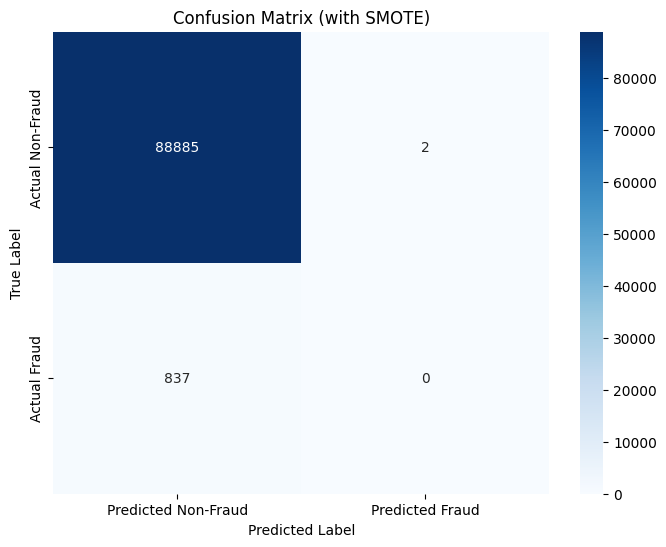

Confusion matrix visualization displayed.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_smote, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'],
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.title('Confusion Matrix (with SMOTE)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Confusion matrix visualization displayed.")

### Tóm Tắt Phát Hiện và Cải Thiện Tiềm Năng

**Tóm tắt hiệu suất mô hình hiện tại:**

Sau khi áp dụng SMOTE và huấn luyện lại mô hình RandomForestClassifier với `class_weight='balanced'`, hiệu suất phát hiện gian lận vẫn còn rất kém. Các chỉ số cho lớp gian lận (`is_fraud=True`) cho thấy:

*   **Precision (Độ chính xác): 0.0000**
*   **Recall (Độ thu hồi): 0.0000**
*   **F1-Score: 0.0000**

Ma trận nhầm lẫn:
```
[[88885     2]
 [  837     0]]
```

Điều này có nghĩa là:
*   Mô hình vẫn không phát hiện được bất kỳ giao dịch gian lận nào (True Positives = 0). Có 837 giao dịch gian lận thực tế bị phân loại sai thành không gian lận (False Negatives).
*   Mô hình hầu như chỉ phân loại tất cả các giao dịch là không gian lận, dẫn đến độ chính xác tổng thể cao (~0.9906) nhưng hoàn toàn không có khả năng phát hiện lớp thiểu số.
*   Chỉ có 2 giao dịch không gian lận bị phân loại sai thành gian lận (False Positives).

**Cải thiện tiềm năng:**

Để cải thiện khả năng phát hiện gian lận của mô hình, cần xem xét các phương pháp sau:

1.  **Kỹ thuật lấy mẫu nâng cao:** SMOTE có thể không đủ trong trường hợp này. Cần thử các biến thể SMOTE khác (ví dụ: Borderline-SMOTE, ADASYN) hoặc các kỹ thuật kết hợp lấy mẫu quá mức/lấy mẫu thiếu (ví dụ: SMOTEENN, SMOTETomek) để tạo ra các mẫu tổng hợp hiệu quả hơn.
2.  **Điều chỉnh ngưỡng phân loại:** Hiện tại, mô hình đang sử dụng ngưỡng mặc định (thường là 0.5). Việc điều chỉnh ngưỡng phân loại đầu ra xác suất của mô hình có thể giúp tăng độ thu hồi (recall) cho lớp gian lận, ngay cả khi độ chính xác (precision) có thể giảm.
3.  **Các thuật toán khác:** Random Forest là một thuật toán mạnh mẽ, nhưng các mô hình dựa trên Gradient Boosting (như XGBoost, LightGBM, CatBoost) thường hoạt động rất tốt với dữ liệu mất cân bằng và có thể mang lại hiệu suất tốt hơn. Hoặc thử các mô hình đặc biệt cho phát hiện dị thường (Anomaly Detection) như One-Class SVM.
4.  **Kỹ thuật kỹ sư đặc trưng (Feature Engineering):** Tạo ra các đặc trưng mới có thể giúp mô hình phân biệt tốt hơn giữa giao dịch gian lận và không gian lận. Ví dụ: tỷ lệ chi tiêu trung bình, số lượng giao dịch trong một khoảng thời gian ngắn, phát hiện các mẫu chi tiêu bất thường dựa trên lịch sử của tài khoản.
5.  **Cost-Sensitive Learning:** Điều chỉnh thuật toán để gán chi phí khác nhau cho các loại lỗi khác nhau (ví dụ: chi phí cao hơn khi bỏ sót giao dịch gian lận).
6.  **Xác thực chéo (Cross-validation):** Sử dụng xác thực chéo để có đánh giá hiệu suất mô hình đáng tin cậy hơn và giảm thiểu sự thiên vị của tập kiểm tra.

Kết quả hiện tại cho thấy đây là một vấn đề phát hiện gian lận rất thách thức do sự mất cân bằng lớp cực đoan và đòi hỏi phải áp dụng các kỹ thuật tiên tiến hơn.

### Tóm Tắt Phát Hiện và Cải Thiện Tiềm Năng

**Tóm tắt hiệu suất mô hình hiện tại:**

Sau khi áp dụng SMOTE và huấn luyện lại mô hình RandomForestClassifier với `class_weight='balanced'`, hiệu suất phát hiện gian lận vẫn còn rất kém. Các chỉ số cho lớp gian lận (`is_fraud=True`) cho thấy:

*   **Precision (Độ chính xác): 0.0000**
*   **Recall (Độ thu hồi): 0.0000**
*   **F1-Score: 0.0000**

Ma trận nhầm lẫn:
```
[[88885     2]
 [  837     0]]
```

Điều này có nghĩa là:
*   Mô hình vẫn không phát hiện được bất kỳ giao dịch gian lận nào (True Positives = 0). Có 837 giao dịch gian lận thực tế bị phân loại sai thành không gian lận (False Negatives).
*   Mô hình hầu như chỉ phân loại tất cả các giao dịch là không gian lận, dẫn đến độ chính xác tổng thể cao (~0.9906) nhưng hoàn toàn không có khả năng phát hiện lớp thiểu số.
*   Chỉ có 2 giao dịch không gian lận bị phân loại sai thành gian lận (False Positives).

**Cải thiện tiềm năng:**

Để cải thiện khả năng phát hiện gian lận của mô hình, cần xem xét các phương pháp sau:

1.  **Kỹ thuật lấy mẫu nâng cao:** SMOTE có thể không đủ trong trường hợp này. Cần thử các biến thể SMOTE khác (ví dụ: Borderline-SMOTE, ADASYN) hoặc các kỹ thuật kết hợp lấy mẫu quá mức/lấy mẫu thiếu (ví dụ: SMOTEENN, SMOTETomek) để tạo ra các mẫu tổng hợp hiệu quả hơn.
2.  **Điều chỉnh ngưỡng phân loại:** Hiện tại, mô hình đang sử dụng ngưỡng mặc định (thường là 0.5). Việc điều chỉnh ngưỡng phân loại đầu ra xác suất của mô hình có thể giúp tăng độ thu hồi (recall) cho lớp gian lận, ngay cả khi độ chính xác (precision) có thể giảm.
3.  **Các thuật toán khác:** Random Forest là một thuật toán mạnh mẽ, nhưng các mô hình dựa trên Gradient Boosting (như XGBoost, LightGBM, CatBoost) thường hoạt động rất tốt với dữ liệu mất cân bằng và có thể mang lại hiệu suất tốt hơn. Hoặc thử các mô hình đặc biệt cho phát hiện dị thường (Anomaly Detection) như One-Class SVM.
4.  **Kỹ thuật kỹ sư đặc trưng (Feature Engineering):** Tạo ra các đặc trưng mới có thể giúp mô hình phân biệt tốt hơn giữa giao dịch gian lận và không gian lận. Ví dụ: tỷ lệ chi tiêu trung bình, số lượng giao dịch trong một khoảng thời gian ngắn, phát hiện các mẫu chi tiêu bất thường dựa trên lịch sử của tài khoản.
5.  **Cost-Sensitive Learning:** Điều chỉnh thuật toán để gán chi phí khác nhau cho các loại lỗi khác nhau (ví dụ: chi phí cao hơn khi bỏ sót giao dịch gian lận).
6.  **Xác thực chéo (Cross-validation):** Sử dụng xác thực chéo để có đánh giá hiệu suất mô hình đáng tin cậy hơn và giảm thiểu sự thiên vị của tập kiểm tra.

Kết quả hiện tại cho thấy đây là một vấn đề phát hiện gian lận rất thách thức do sự mất cân bằng lớp cực đoan và đòi hỏi phải áp dụng các kỹ thuật tiên tiến hơn.

## Trực Quan Hóa Kết Quả Đánh Giá

### Subtask:
Trực quan hóa ma trận nhầm lẫn hoặc đường cong ROC (Receiver Operating Characteristic) để cung cấp cái nhìn trực quan về hiệu suất của mô hình.


**Reasoning**:
To visualize the ROC curve, I will first calculate the predicted probabilities for the positive class (fraud) on the test set using `predict_proba`. Then, I will use `roc_curve` and `auc` from `sklearn.metrics` to compute the False Positive Rate (FPR), True Positive Rate (TPR), and the Area Under the Curve (AUC). Finally, I will plot the ROC curve using `matplotlib.pyplot` with appropriate labels, title, and AUC score.



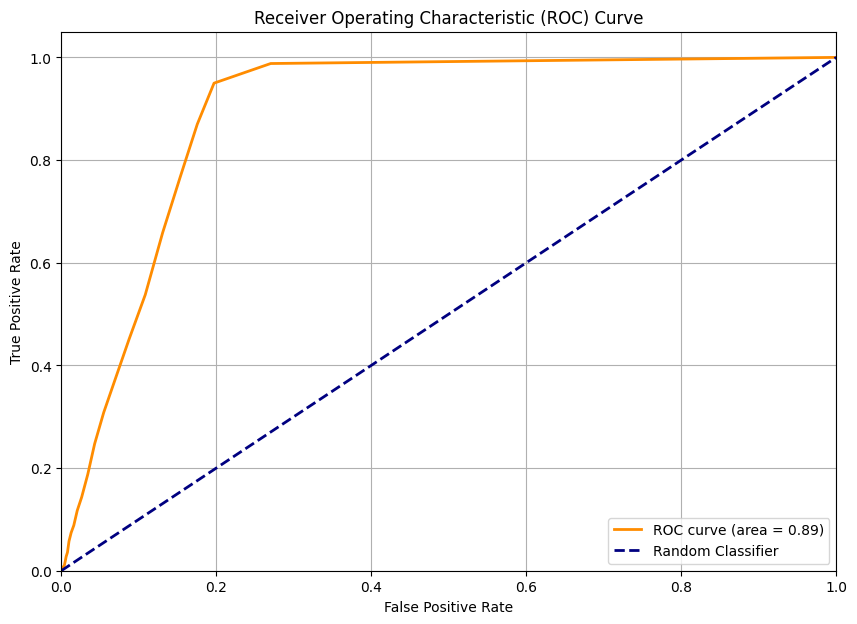

ROC AUC: 0.8946


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (True or fraud)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=True)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"ROC AUC: {roc_auc:.4f}")

## Final Task

### Subtask:
Tóm tắt kết quả huấn luyện và đánh giá mô hình, bao gồm các chỉ số hiệu suất chính và thảo luận về những phát hiện. Đề xuất các bước cải thiện mô hình hoặc triển khai nếu phù hợp.


## Summary:

### Data Analysis Key Findings

*   **Initial Data State**: The dataset initially contained 448,620 entries and 18 columns. Significant missing values were present, notably in `fraud_type` (over 99\%) and `time_since_last_transaction` (approximately 78%).
*   **Preprocessing Steps**:
    *   The `fraud_type` column was dropped.
    *   Missing values in `time_since_last_transaction` were imputed with the median.
    *   Rows with single missing values in `payment_channel`, `ip_address`, and `device_hash` were dropped, resulting in 448,619 entries.
    *   Temporal features (`hour`, `day_of_week`, `month`) were extracted from the `timestamp` column.
    *   High-cardinality identifier columns (`transaction_id`, `sender_account`, `receiver_account`, `ip_address`, `device_hash`) were removed.
    *   Categorical features were one-hot encoded, and numerical features were scaled.
    *   The final preprocessed feature matrix `X_processed_df` has a shape of (448619, 36).
*   **Class Imbalance**: The target variable `is_fraud` exhibits extreme class imbalance, with 444,434 non-fraudulent transactions (`False`) and only 4,185 fraudulent transactions (`True`). This translates to approximately 99.07% non-fraud and 0.93% fraud.
*   **Data Splitting**: The data was successfully split into training (80%) and testing (20%) sets using stratification, maintaining the class distribution (approximately 0.9907 for non-fraud and 0.0093 for fraud in both sets).
*   **Model Performance (RandomForestClassifier with SMOTE)**:
    *   Despite using SMOTE for oversampling and `class_weight='balanced'` in the RandomForestClassifier, the model failed to detect any fraudulent transactions.
    *   The precision, recall, and F1-score for the fraud class (`is_fraud=True`) were all 0.0000.
    *   The confusion matrix showed:
        *   88,885 True Negatives (correctly identified non-fraud).
        *   2 False Positives (non-fraud incorrectly identified as fraud).
        *   837 False Negatives (actual fraud incorrectly identified as non-fraud).
        *   0 True Positives (no actual fraud identified).
    *   The overall accuracy was high (0.9906) but misleading due to the severe class imbalance and the model's inability to identify the minority class.
*   **ROC AUC Score**: The Receiver Operating Characteristic (ROC) curve analysis yielded an Area Under the Curve (AUC) of 0.8946. This indicates that while the model has some discriminatory power, its current thresholding is ineffective for fraud detection.

### Insights or Next Steps

*   The current model setup (RandomForestClassifier with SMOTE and default thresholding) is inadequate for fraud detection, as evidenced by its inability to identify any fraudulent transactions. The high ROC AUC suggests the model can differentiate between classes to some extent, implying that adjusting the classification threshold is a critical next step to balance precision and recall for the fraud class.
*   To improve fraud detection, explore more advanced imbalance handling techniques beyond basic SMOTE (e.g., Borderline-SMOTE, ADASYN, SMOTEENN), investigate other classification algorithms known for handling imbalanced data (e.g., XGBoost, LightGBM, CatBoost), and consider feature engineering to create more distinctive features related to fraudulent activities.
